<a href="https://colab.research.google.com/github/antonellagambarte/proyecto-final-CEIA/blob/main/LIMPIEZA_DATASET_NHANES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [114]:
# Leer el archivo
ruta_archivo = '/content/drive/My Drive/NHANES/df_min.csv'
df = pd.read_csv(ruta_archivo)

# Verificar que los datos llegaron bien
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 56 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id_paciente                             5568 non-null   float64
 1   tipo_entrevista                         5568 non-null   float64
 2   edad                                    5568 non-null   float64
 3   genero                                  5568 non-null   float64
 4   presion_sis_1                           4658 non-null   float64
 5   presion_sis_2                           4885 non-null   float64
 6   presion_sis_3                           4872 non-null   float64
 7   colesterol_total                        4936 non-null   float64
 8   hdl                                     4936 non-null   float64
 9   ldl                                     2368 non-null   float64
 10  trigliceridos                           2393 non-null   floa

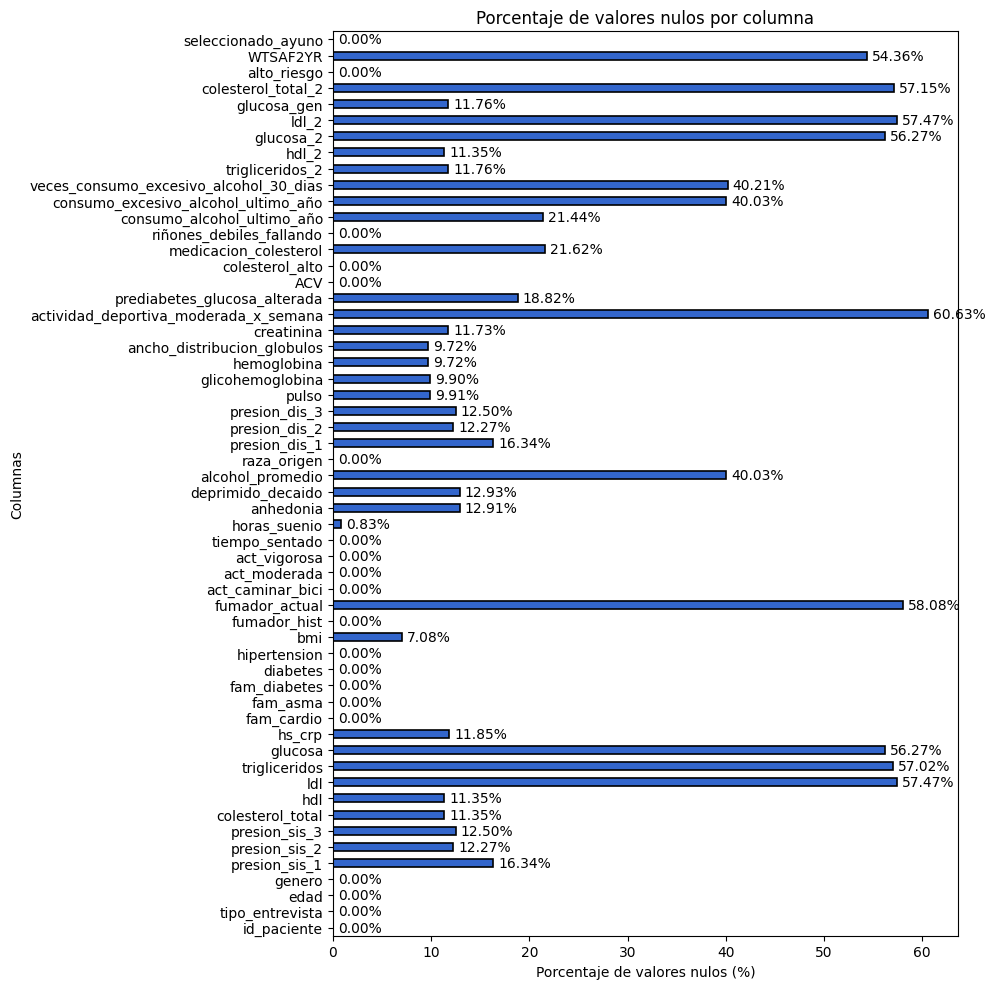

In [115]:
porcentaje_nulos = df.isna().mean().round(4) * 100

plt.figure(figsize=(10, 10))
porcentaje_nulos.plot(kind='barh', color="#3366CC", edgecolor='black', linewidth=1.2)

plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Porcentaje de valores nulos (%)')
plt.ylabel('Columnas')

for index, value in enumerate(porcentaje_nulos):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center')

plt.tight_layout()
plt.show()

### **BMI**

In [116]:
print("--- PERFIL DE NULOS EN BMI ---")

# 1. ¿Cuántos nulos hay realmente?
total_nulos_bmi = df['bmi'].isnull().sum()
print(f"Total nulos: {total_nulos_bmi} ({ (total_nulos_bmi/len(df))*100 :.2f}%)")

# 2. ¿Hay sesgo de género?
print("\nDistribución por Género en nulos de BMI:")
print(df[df['bmi'].isnull()]['genero'].value_counts(normalize=True))

# 3. ¿Hay sesgo por Edad?
print("\nEdad promedio de los nulos:")
print(df[df['bmi'].isnull()]['edad'].mean())
print("Edad promedio de los NO nulos:")
print(df[df['bmi'].notnull()]['edad'].mean())

# 4. ¿Están relacionados con los nulos de presión?
# Usamos 'presion_sis_1' que ya viene en el CSV original
ambos_nulos = df[df['bmi'].isnull() & df['presion_sis_1'].isnull()].shape[0]
print(f"\nPacientes que no tienen NI presión (Medida 1) NI BMI: {ambos_nulos}")

--- PERFIL DE NULOS EN BMI ---
Total nulos: 394 (7.08%)

Distribución por Género en nulos de BMI:
genero
1.0    0.530457
2.0    0.469543
Name: proportion, dtype: float64

Edad promedio de los nulos:
54.9263959390863
Edad promedio de los NO nulos:
51.24101275608813

Pacientes que no tienen NI presión (Medida 1) NI BMI: 335


Imputación con mediana por rango de edad

In [117]:
# 1. Crear el rango de edad (décadas) para que la imputación sea biológicamente coherente
df['rango_edad'] = (df['edad'] // 10) * 10

# 2. Realizar la imputación por estratos
# Esto asigna la mediana de BMI de personas del mismo sexo y rango de edad
df['bmi'] = df.groupby(['genero', 'rango_edad'])['bmi'].transform(lambda x: x.fillna(x.median()))

# 3. Red de seguridad
# Por si existe algún grupo demográfico sin ningún dato (muy poco probable en NHANES)
if df['bmi'].isnull().any():
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())

print("--- VERIFICACIÓN DE BMI ---")
print(f"Nulos restantes en BMI: {df['bmi'].isnull().sum()}")
print(f"Estadísticas del BMI post-imputación:\n{df['bmi'].describe()}")

--- VERIFICACIÓN DE BMI ---
Nulos restantes en BMI: 0
Estadísticas del BMI post-imputación:
count    5568.000000
mean       29.750108
std         7.142021
min        14.200000
25%        25.100000
50%        28.600000
75%        33.100000
max        86.200000
Name: bmi, dtype: float64


### **PRESION**

En este caso, se tienen 3 medidas. Primero, para cada fila, vamos a hacer el promedio de los valores que se tengan para que obtengamos una sola columna con los valores de presion sistolica y otra distolica.

In [118]:
# 1. Definimos las columnas de presión según tu nueva lista
cols_sis = ['presion_sis_1', 'presion_sis_2', 'presion_sis_3']
cols_dis = ['presion_dis_1', 'presion_dis_2', 'presion_dis_3']

# 2. Creamos la medida final (promedio de las que NO son NaN)
df['presion_sistolica_final'] = df[cols_sis].mean(axis=1)
df['presion_diastolica_final'] = df[cols_dis].mean(axis=1)

# 3. Auditoría de rescate
nulos_antes = df['presion_sis_1'].isnull().sum()
nulos_despues = df['presion_sistolica_final'].isnull().sum()

print(f"Nulos originales en 'presion_sis_1': {nulos_antes}")
print(f"Nulos finales tras el rescate: {nulos_despues}")
print(f"¡Logramos recuperar {nulos_antes - nulos_despues} pacientes!")

Nulos originales en 'presion_sis_1': 910
Nulos finales tras el rescate: 573
¡Logramos recuperar 337 pacientes!


In [119]:
# Comparamos la edad media de los que tienen presión vs los que no
print("--- COMPARATIVA DE NULOS DE PRESIÓN ---")
print("Edad promedio con presión:")
print(df[df['presion_sistolica_final'].notnull()]['edad'].mean())

print("\nEdad promedio de los nulos:")
print(df[df['presion_sistolica_final'].isnull()]['edad'].mean())

--- COMPARATIVA DE NULOS DE PRESIÓN ---
Edad promedio con presión:
51.44244244244244

Edad promedio de los nulos:
52.019197207678886


Se compara la imputación con mediana por rango de edad e imputacion con knn

In [120]:
# Creamos copias para comparar
df_mediana = df.copy()
df_knn = df.copy()

# --- PRUEBA OPCIÓN 2: Mediana por Grupos de Edad ---
df_mediana['rango_edad'] = (df_mediana['edad'] // 10) * 10
df_mediana['presion_sistolica_final'] = df_mediana.groupby('rango_edad')['presion_sistolica_final'].transform(lambda x: x.fillna(x.median()))

# --- PRUEBA OPCIÓN 3: KNN (Usando variables clave) ---
# Seleccionamos columnas que ayudan a predecir (deben ser numéricas y sin nulos si es posible)
cols_knn = ['edad', 'genero', 'bmi', 'diabetes', 'presion_sistolica_final']
imputer = KNNImputer(n_neighbors=5)
# Solo imputamos en la copia
df_knn[cols_knn] = imputer.fit_transform(df_knn[cols_knn])

# --- COMPARACIÓN DE RESULTADOS ---
print("ESTADÍSTICAS DE PRESIÓN SISTÓLICA")
print(f"Original (con nulos): Media {df['presion_sistolica_final'].mean():.2f}, Desv. Est. {df['presion_sistolica_final'].std():.2f}")
print(f"Post Mediana Grupos:  Media {df_mediana['presion_sistolica_final'].mean():.2f}, Desv. Est. {df_mediana['presion_sistolica_final'].std():.2f}")
print(f"Post KNN:             Media {df_knn['presion_sistolica_final'].mean():.2f}, Desv. Est. {df_knn['presion_sistolica_final'].std():.2f}")

ESTADÍSTICAS DE PRESIÓN SISTÓLICA
Original (con nulos): Media 127.13, Desv. Est. 20.17
Post Mediana Grupos:  Media 126.99, Desv. Est. 19.37
Post KNN:             Media 127.18, Desv. Est. 19.62


KNN es mas cercano a la desviación estandar antes de imputar, asi que se utiliza knn

In [121]:
# 1. Primero aseguramos un BMI básico (mediana) para que no rompa el KNN
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# 2. Definimos las columnas que "se ayudan" entre sí
# Incluimos variables que tienen relación biológica con la presión
cols_para_knn = ['edad', 'genero', 'bmi', 'diabetes', 'presion_sistolica_final', 'presion_diastolica_final']

imputer = KNNImputer(n_neighbors=5)

# 3. Aplicamos la imputación
df[cols_para_knn] = imputer.fit_transform(df[cols_para_knn])

# 4. Verificación final
print(f"Nulos restantes en Sistólica Final: {df['presion_sistolica_final'].isnull().sum()}")
print(f"Nulos restantes en Diastólica Final: {df['presion_diastolica_final'].isnull().sum()}")

Nulos restantes en Sistólica Final: 0
Nulos restantes en Diastólica Final: 0


Borro columnas de presion

In [122]:
# Lista de columnas que ya procesamos y consolidamos
columnas_a_eliminar = [
    'presion_sis_1', 'presion_sis_2', 'presion_sis_3',
    'presion_dis_1', 'presion_dis_2', 'presion_dis_3',
    'rango_edad' # Esta la creamos solo para la imputación
]

# Las eliminamos
df.drop(columns=columnas_a_eliminar, inplace=True)

print("--- LIMPIEZA DE COLUMNAS COMPLETADA ---")
print(f"Columnas restantes: {len(df.columns)}")

--- LIMPIEZA DE COLUMNAS COMPLETADA ---
Columnas restantes: 52


###**Trgliceridos**

Recordemos que esta variable se encuentra presente en 2 unidades. Usamos la que se encuentra en mmol/L para recuperar los datos en mg/dL . El factor de conversión, según la documentación es 88.57

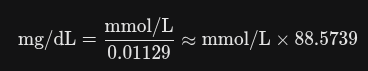

In [123]:
# 1. Antes del rescate, veamos cuántos nulos tenemos
nulos_trig_antes = df['trigliceridos'].isnull().sum()

# 2. Rescatamos: Si trigliceridos es nulo, lo llenamos con (trigliceridos_2 * 88.57)
# Usamos 88.57 que es el factor estándar de conversión para triglicéridos
df['trigliceridos'] = df['trigliceridos'].fillna(df['trigliceridos_2'] * 88.57)

# 3. Verificamos el impacto
nulos_trig_despues = df['trigliceridos'].isnull().sum()
print(f"Nulos en trigliceridos ANTES: {nulos_trig_antes}")
print(f"Nulos en trigliceridos DESPUÉS: {nulos_trig_despues}")
print(f"¡Rescatamos {nulos_trig_antes - nulos_trig_despues} registros!")

Nulos en trigliceridos ANTES: 3175
Nulos en trigliceridos DESPUÉS: 644
¡Rescatamos 2531 registros!


In [124]:
# 1. Preparar datos
df_mediana = df.copy()
df_knn = df.copy()

# 2. Imputar con Mediana
df_mediana['trigliceridos'] = df_mediana['trigliceridos'].fillna(df_mediana['trigliceridos'].median())

# 3. Imputar con KNN
from sklearn.impute import KNNImputer
cols_para_knn = ['edad', 'genero', 'bmi', 'diabetes', 'trigliceridos']
imputer = KNNImputer(n_neighbors=5)
df_knn[cols_para_knn] = imputer.fit_transform(df_knn[cols_para_knn])

# 4. Comparativa Final
print("--- COMPARATIVA DE MÉTODOS ---")
print(f"ORIGINAL (con nulos)  | Media: {df['trigliceridos'].mean():.2f} | Std: {df['trigliceridos'].std():.2f}")
print(f"MÉTODO MEDIANA        | Media: {df_mediana['trigliceridos'].mean():.2f} | Std: {df_mediana['trigliceridos'].std():.2f}")
print(f"MÉTODO KNN            | Media: {df_knn['trigliceridos'].mean():.2f} | Std: {df_knn['trigliceridos'].std():.2f}")

--- COMPARATIVA DE MÉTODOS ---
ORIGINAL (con nulos)  | Media: 137.85 | Std: 113.67
MÉTODO MEDIANA        | Media: 134.63 | Std: 107.26
MÉTODO KNN            | Media: 138.20 | Std: 108.59


kNN es la mejor opcion para imputar el 11,57% restante

In [125]:
# 1. Seleccionamos las columnas para el modelo KNN
# Incluimos las variables que ya tenemos limpias (edad, genero, bmi, diabetes)
# para que ayuden a predecir los triglicéridos faltantes.
cols_para_knn = ['edad', 'genero', 'bmi', 'diabetes', 'trigliceridos']

# 2. Configuramos e aplicamos el imputador
imputer = KNNImputer(n_neighbors=5)
df[cols_para_knn] = imputer.fit_transform(df[cols_para_knn])

# 3. Verificación de cierre
nulos_finales = df['trigliceridos'].isnull().sum()
print(f"--- CIERRE DE TRIGLICÉRIDOS ---")
print(f"Nulos restantes: {nulos_finales}")
print(f"Estadísticas finales:\n{df['trigliceridos'].describe()}")

--- CIERRE DE TRIGLICÉRIDOS ---
Nulos restantes: 0
Estadísticas finales:
count    5568.000000
mean      138.197871
std       108.589805
min        10.000000
25%        78.000000
50%       113.000000
75%       165.005910
max      2684.000000
Name: trigliceridos, dtype: float64


In [126]:
# Eliminamos triglicéridos en mmol/L
df.drop(columns=['trigliceridos_2'], inplace=True, errors='ignore')

###**HDL**

In [127]:
# 1. Comparamos los nulos de ambas columnas de HDL
print(f"Faltantes en HDL (hdl - mg/dL): {df['hdl'].isnull().sum()}")
print(f"Faltantes en HDL_2 (hdl_2 - mmol/L): {df['hdl_2'].isnull().sum()}")

# 2. Verificamos si hay casos donde hdl_2 puede 'salvar' a hdl
casos_recuperables_hdl = df[df['hdl'].isnull() & df['hdl_2'].notnull()].shape[0]
print(f"Casos donde hdl_2 podría 'salvar' a hdl: {casos_recuperables_hdl}")

Faltantes en HDL (hdl - mg/dL): 632
Faltantes en HDL_2 (hdl_2 - mmol/L): 632
Casos donde hdl_2 podría 'salvar' a hdl: 0


In [128]:
# 1. Guardamos stats actuales
stats_hdl_antes = {
    'media': df['hdl'].mean(),
    'std': df['hdl'].std()
}

# 2. Preparamos KNN
from sklearn.impute import KNNImputer
# Incluimos género y bmi porque son los mejores predictores del hdl
cols_hdl_knn = ['genero', 'bmi', 'edad', 'hdl']
imputer_hdl = KNNImputer(n_neighbors=5)

# 3. Comparativa (en un df temporal)
df_hdl_knn = df.copy()
df_hdl_knn[cols_hdl_knn] = imputer_hdl.fit_transform(df_hdl_knn[cols_hdl_knn])

# 4. Resultados
print("--- AUDITORÍA DE IMPUTACIÓN HDL ---")
print(f"ORIGINAL | Media: {stats_hdl_antes['media']:.2f} | Std: {stats_hdl_antes['std']:.2f}")
print(f"POST KNN | Media: {df_hdl_knn['hdl'].mean():.2f} | Std: {df_hdl_knn['hdl'].std():.2f}")

--- AUDITORÍA DE IMPUTACIÓN HDL ---
ORIGINAL | Media: 53.26 | Std: 15.68
POST KNN | Media: 53.27 | Std: 15.11


In [129]:
# 1. Aplicamos el KNN definitivo
from sklearn.impute import KNNImputer
cols_hdl_knn = ['genero', 'bmi', 'edad', 'hdl']
imputer_hdl = KNNImputer(n_neighbors=5)
df[cols_hdl_knn] = imputer_hdl.fit_transform(df[cols_hdl_knn])

# 2. Eliminamos la columna HDL_2
df.drop(columns=['hdl_2'], inplace=True, errors='ignore')

###**COLESTEROL TOTAL**

Verificamos si podemos recuperar algo

In [130]:
# 1. Verificamos si hay rescate posible
casos_recuperables_col = df[df['colesterol_total'].isnull() & df['colesterol_total_2'].notnull()].shape[0]

# 2. Rescatamos (si existen casos) y luego eliminamos la columna auxiliar
if casos_recuperables_col > 0:
    df['colesterol_total'] = df['colesterol_total'].fillna(df['colesterol_total_2'] / 0.02586)
    print(f"¡Se rescataron {casos_recuperables_col} registros de Colesterol Total!")
else:
    print("No hubo casos para rescatar mediante conversión (los nulos coinciden).")

# Eliminamos la columna _2 para mantener el df limpio
df.drop(columns=['colesterol_total_2'], inplace=True, errors='ignore')

No hubo casos para rescatar mediante conversión (los nulos coinciden).


In [131]:
# 1. Guardamos el estado original (antes de imputar)
media_antes = df['colesterol_total'].mean()
std_antes = df['colesterol_total'].std()

# 2. Aplicamos la imputación KNN
from sklearn.impute import KNNImputer
cols_col_knn = ['edad', 'genero', 'bmi', 'diabetes', 'colesterol_total']
imputer_col = KNNImputer(n_neighbors=5)
df[cols_col_knn] = imputer_col.fit_transform(df[cols_col_knn])

# 3. Calculamos el estado final
media_despues = df['colesterol_total'].mean()
std_despues = df['colesterol_total'].std()

# 4. Reporte de impacto
print("--- IMPACTO DE IMPUTACIÓN (COLESTEROL TOTAL) ---")
print(f"MEDIA:    Antes {media_antes:.2f} -> Después {media_despues:.2f} (Cambio: {((media_despues - media_antes)/media_antes)*100:.4f}%)")
print(f"DESV.EST: Antes {std_antes:.2f} -> Después {std_despues:.2f} (Cambio: {((std_despues - std_antes)/std_antes)*100:.4f}%)")
print(f"Nulos restantes: {df['colesterol_total'].isnull().sum()}")

--- IMPACTO DE IMPUTACIÓN (COLESTEROL TOTAL) ---
MEDIA:    Antes 188.08 -> Después 188.02 (Cambio: -0.0323%)
DESV.EST: Antes 41.29 -> Después 39.58 (Cambio: -4.1315%)
Nulos restantes: 0


In [132]:
# Eliminamos la columna de unidades internacionales de Colesterol Total
df.drop(columns=['colesterol_total_2'], inplace=True, errors='ignore')


###**LDL**

Como ya enemos los valores de colesterol total, hdl y trigliceridos, podemos calcular hdl usando la siguiente formula:
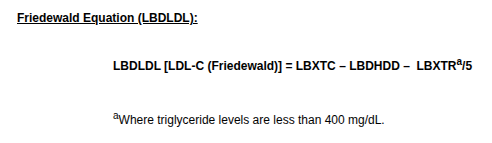

In [136]:
# 1. Función basada estrictamente en la documentación de NHANES
def rescatar_ldl_friedewald(row):
    # Si el LDL es nulo, aplicamos la fórmula oficial
    if pd.isnull(row['ldl']):
        # Verificamos la restricción técnica de Friedewald (TG < 400 mg/dL)
        if row['trigliceridos'] < 400:
            # Fórmula: Total - HDL - (TG / 5)
            return row['colesterol_total'] - row['hdl'] - (row['trigliceridos'] / 5)
    return row['ldl']

# 2. Aplicamos el rescate
nulos_antes = df['ldl'].isnull().sum()
df['ldl'] = df.apply(rescatar_ldl_friedewald, axis=1)
nulos_despues = df['ldl'].isnull().sum()

# 3. Limpieza de columnas sobrantes
df.drop(columns=['ldl_2'], inplace=True, errors='ignore')

print("--- RESULTADO DEL RESCATE SEGÚN DOCUMENTACIÓN ---")
print(f"Nulos iniciales en LDL: {nulos_antes}")
print(f"Nulos después de aplicar Friedewald: {nulos_despues}")
print(f"¡Logramos rescatar {nulos_antes - nulos_despues} pacientes!")

--- RESULTADO DEL RESCATE SEGÚN DOCUMENTACIÓN ---
Nulos iniciales en LDL: 3200
Nulos después de aplicar Friedewald: 134
¡Logramos rescatar 3066 pacientes!


Restante con KNN

In [137]:
# 1. Definimos las columnas para el cierre final de lípidos
cols_ldl_knn = ['edad', 'genero', 'bmi', 'diabetes', 'trigliceridos', 'hdl', 'colesterol_total', 'ldl']

# 2. Aplicamos el KNN final
imputer_ldl = KNNImputer(n_neighbors=5)
df[cols_ldl_knn] = imputer_ldl.fit_transform(df[cols_ldl_knn])

print(f"--- CIERRE FINAL DE LÍPIDOS ---")
print(f"Nulos restantes en LDL: {df['ldl'].isnull().sum()}")
print(f"Dataset de lípidos completado al 100%.")

--- CIERRE FINAL DE LÍPIDOS ---
Nulos restantes en LDL: 0
Dataset de lípidos completado al 100%.


-------------------------------------------------------------------------

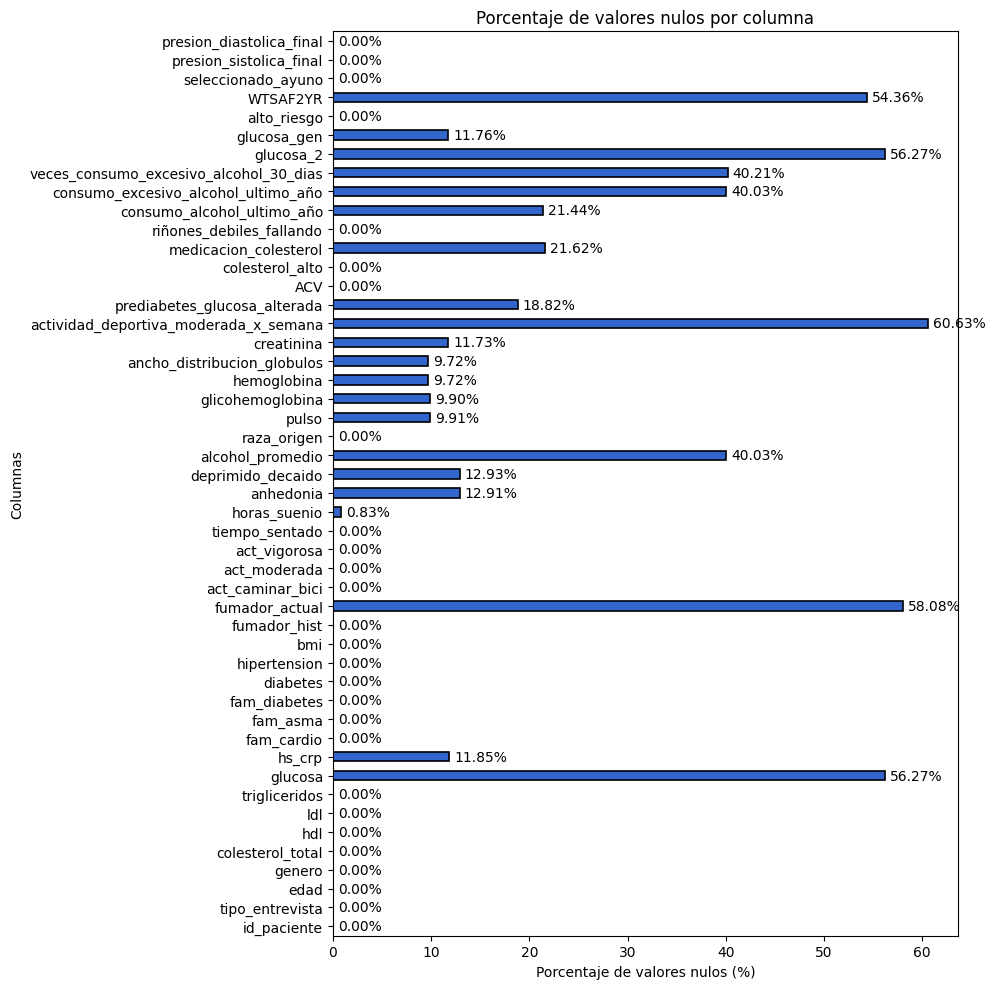

In [138]:
porcentaje_nulos = df.isna().mean().round(4) * 100

plt.figure(figsize=(10, 10))
porcentaje_nulos.plot(kind='barh', color="#3366CC", edgecolor='black', linewidth=1.2)

plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Porcentaje de valores nulos (%)')
plt.ylabel('Columnas')

for index, value in enumerate(porcentaje_nulos):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center')

plt.tight_layout()
plt.show()

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 48 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id_paciente                             5568 non-null   float64
 1   tipo_entrevista                         5568 non-null   float64
 2   edad                                    5568 non-null   float64
 3   genero                                  5568 non-null   float64
 4   colesterol_total                        5568 non-null   float64
 5   hdl                                     5568 non-null   float64
 6   ldl                                     5568 non-null   float64
 7   trigliceridos                           5568 non-null   float64
 8   glucosa                                 2435 non-null   float64
 9   hs_crp                                  4908 non-null   float64
 10  fam_cardio                              5568 non-null   floa

| Variable | Imputación |
| --- | --- |
| edad | - |
| genero | - |
| presion_sis_1 | PROM + KNN |
| presion_sis_2 | PROM + KNN |
| presion_sis_3 | PROM + KNN |
| colesterol_total | KNN |
| hdl | KNN |
| ldl | Cálculo + KNN |
| trigliceridos | KNN |
| glucosa |  |
| proteina_c |  |
| fam_cardio | - |
| fam_asma | - |
| fam_diabetes | - |
| diabetes | - |
| hipertension | - |
| bmi | Mediana por rango de edad |
| fumador_hist | - |
| fumador_actual |  |
| act_caminar_bici | - |
| act_moderada | - |
| act_vigorosa | - |
| tiempo_sentado | - |
| horas_suenio |  |
| anhedonia |  |
| deprimido_decaido |  |
| alcohol_promedio |  |
| raza_origen | - |
| presion_dis_1 | PROM + KNN |
| presion_dis_2 | PROM + KNN |
| presion_dis_3 | PROM + KNN |
| pulso |  |
| glicohemoglobina |  |
| hemoglobina |  |
| ancho_distribucion_globulos |  |
| creatinina |  |
| actividad_deportiva_moderada_x_semana |  |
| prediabetes_glucosa_alterada |  |
| ACV | - |
| colesterol_alto | - |
| medicacion_colesterol |  |
| riñones_debiles_fallando | - |
| consumo_alcohol_ultimo_año |  |
| consumo_excesivo_alcohol_ultimo_año |  |
| veces_consumo_excesivo_alcohol_30_dias |  |
| consumo_actual_tab_sin_humo | - |


In [135]:
# Crear diccionario con los nombres cortos que corresponden solo a tus features
short_names_dict = {
    "SEQN": "id_paciente",
    "RIDSTATR": "tipo_entrevista",
    "RIDAGEYR": "edad",
    "RIAGENDR": "genero",
    "BPXSY1": "presion_sis_1",
    "BPXSY2": "presion_sis_2",
    "BPXSY3": "presion_sis_3",
    "LBXTC": "colesterol_total",
    "LBDHDD": "hdl",
    "LBDLDL": "ldl",
    "LBXTR": "trigliceridos",
    "LBXGLU": "glucosa",
    "LBXHSCRP": "proteina_c",
    "MCQ300A": "fam_cardio",
    "MCQ300B": "fam_asma",
    "MCQ300C": "fam_diabetes",
    "DIQ010": "diabetes",
    "BPQ020": "hipertension",
    "BMXBMI": "bmi",
    "SMQ020": "fumador_hist",
    "SMQ040": "fumador_actual",
    "PAQ605": "act_caminar_bici",
    "PAQ620": "act_moderada",
    "PAQ635": "act_vigorosa",
    "PAQ650": "tiempo_sentado",
    "SLD012": "horas_suenio",
    "DPQ010": "anhedonia",
    "DPQ020": "deprimido_decaido",
    # "DPQ030": "depresion_3",
    # "DPQ040": "depresion_4",
    # "DPQ050": "depresion_5",
    # "DPQ060": "depresion_6",
    # "DPQ070": "depresion_7",
    # "DPQ080": "depresion_8",
    # "DPQ090": "depresion_9",
    "ALQ130": "alcohol_promedio",
    "DR1TSUGR": "azucar_total_dia",
    "SMQ910": "consumo_actual_tab_sin_humo",
    #
    # "RIDRETH1": "Recodificación de información reportada sobre raza y origen hispano",
    "RIDRETH3": "raza_origen",
    "BPXDI1" : "presion_dis_1",
    "BPXDI2" : "presion_dis_2",
    "BPXDI3" : "presion_dis_3",
    "BPXPULS": "pulso", # numerica binaria
    "LBXGH" :	"glicohemoglobina", # numerica
    "LBXHGB":  "hemoglobina",
    "LBXRDW": "ancho_distribucion_globulos",
    "LBXSCR": "creatinina",
    # "PAQ665": "actividad_deportiva moderada, sí/no)",
    "PAQ670": "actividad_deportiva_moderada_x_semana",
    "DIQ160": "prediabetes_glucosa_alterada",
    "MCQ160F": "ACV",
    "BPQ080": "colesterol_alto",
    "BPQ090D": "medicacion_colesterol",
    "KIQ022" : "riñones_debiles_fallando",
    "ALQ121": "consumo_alcohol_ultimo_año",
    "ALQ142": "consumo_excesivo_alcohol_ultimo_año",
    "ALQ170": "veces_consumo_excesivo_alcohol_30_dias",
    "LBDSTRSI": "trigliceridos_2",
    "LBDHDDSI": "hdl_2",
    "LBDGLUSI": "glucosa_2",
    "LBDLDLSI":"ldl_2",
    "LBXSGL": "glucosa_gen"
}